In [ ]:
!pip install pygeos
!pip install rtree
!pip install pyproj
!pip install geopandas


     |████████████████████████████████| 2.1 MB 4.8 MB/s 
     |████████████████████████████████| 994 kB 5.1 MB/s 
     |████████████████████████████████| 6.3 MB 4.7 MB/s 
     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 15.4 MB 56.9 MB/s 


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_curve, roc_auc_score
)                           
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import tree
import pygeos
import rtree
import shapely
import pyproj
import geopandas
import seaborn as sns
from collections import Counter
import math
pd.set_option('display.max_columns',None)
import requests


def download(name):
  with open(name, 'wb') as f:
    f.write(requests.get('https://ilozue.com/cs109a/'+name).content) 

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# Joining in geographic data
Our first step is to supplement the raw data with more geographic information. We do this by matching the coordinates of accidents to shapefiles of boroughs, census tracts, and Public Use Microdata Areas (PUMAs, which are an alternative tabulation unit in the census). This allows us to reduce the number of observations with missing borough data and to incorporate demographic, economic and commuting information on the areas in which accidents occurred. 

In [ ]:
#download all accident and geographic data
download('NYC Accidents 2020 Cleanedish.csv')
download('borough.dbf')
download('borough.prj')
download('borough.shp')
download('borough.shx')
download('puma.dbf')
download('puma.prj')
download('puma.shp')
download('puma.shx')
download('tract.dbf')
download('tract.prj')
download('tract.shp')
download('tract.shx')


#read in all the data, create copy of main df
df = pd.read_csv("NYC Accidents 2020 Cleanedish.csv")
coords = df[["LATITUDE", "LONGITUDE"]]
boro_polys = geopandas.GeoDataFrame.from_file("borough.shp")
puma_polys = geopandas.GeoDataFrame.from_file("puma.shp")
tract_polys = geopandas.GeoDataFrame.from_file("tract.shp")


In [ ]:
#get the coordinates into the right shape 
coords["geometry"] = coords.apply(lambda row: shapely.geometry.Point(row["LONGITUDE"], row["LATITUDE"]), axis=1)
#put coordinates into geodata frame
boro_points = geopandas.GeoDataFrame(coords['geometry'], geometry="geometry")
puma_points = geopandas.GeoDataFrame(coords['geometry'], geometry="geometry")
tract_points = geopandas.GeoDataFrame(coords['geometry'], geometry="geometry")
#makr sure coordinate systems match between coordinates and polygons
boro_points.crs = boro_polys.crs
puma_points.crs = puma_polys.crs
tract_points.crs = tract_polys.crs
#do the join
boro_result = geopandas.tools.sjoin(boro_points, boro_polys, how="left") #this is same number of rows as df, so we can just add the column
puma_result = geopandas.tools.sjoin(puma_points, puma_polys, how="left")
tract_result = geopandas.tools.sjoin(tract_points, tract_polys, how="left")

#add borough and Census Data compliant tracts to main dataset
#df = df[~df.index.duplicated()]
puma_result = puma_result[~puma_result.index.duplicated()]
tract_result = tract_result[~tract_result.index.duplicated()]

df["borough"] = boro_result["boro_name"]
df["GEOID10"] = '7950000US'+puma_result["GEOID10"]
df["GEOID"] = '1400000US'+tract_result["GEOID"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#Download and import PUMA Census data while setting indexes
download('education.csv')
download('median age.csv')
download('income.csv')
download('commuting.csv')
df_degree = pd.read_csv("education.csv",index_col='id')
df_income = pd.read_csv("income.csv",index_col='id')
df_age = pd.read_csv("median age.csv",index_col='id')
df_comm = pd.read_csv("commuting.csv",index_col='id')

df_pumadata = pd.DataFrame()

#generate commuting ratios
df_pumadata['Drive Alone %'] = df_comm['Estimate!!Car, truck, or van -- drove alone!!Workers 16 years and over']/df_comm['Estimate!!Total!!Workers 16 years and over']
df_pumadata['Drive At All %']  = (df_comm['Estimate!!Car, truck, or van -- carpooled!!Workers 16 years and over']+df_comm['Estimate!!Car, truck, or van -- drove alone!!Workers 16 years and over'])/df_comm['Estimate!!Total!!Workers 16 years and over']
df_pumadata['Transit %']  = df_comm['Estimate!!Public transportation (excluding taxicab)!!Workers 16 years and over']/df_comm['Estimate!!Total!!Workers 16 years and over']

#Add other data
df_pumadata['Median Income'] = df_income['Estimate!!Households!!Median income (dollars)']
df_pumadata['Median Age'] = df_age['Estimate!!Total!!Total population!!SUMMARY INDICATORS!!Median age (years)']
df_pumadata['HS+'] = df_degree['Estimate!!Percent!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!High school graduate or higher']
df_pumadata['BA+'] = df_degree["Estimate!!Percent!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree or higher"]
#df_pumadata['Tract Population'] = df_age['Estimate!!Total!!Total population'] #No longer needed
df_pumadata['PUMA Name'] = df_age['Geographic Area Name']

#Merge with main set
df = df.merge(df_pumadata, how='left', left_on='GEOID10', right_on='id', suffixes=('_o', '_a'))



In [ ]:
#import tract data
download('housing units.csv')
download('race.csv')
download('race 18+.csv')
download('group.csv')
df_units = pd.read_csv("housing units.csv", index_col='id')
df_race = pd.read_csv("race.csv",index_col='id')
df_race18 = pd.read_csv("race 18+.csv",index_col='id')
df_group = pd.read_csv("group.csv",index_col='id')

#extract relevant tract data
df_tractdata = pd.DataFrame()
df_tractdata['Non-Minority White %'] = df_race[' !!Total:!!Population of one race:!!White alone']/df_race[' !!Total:']
df_tractdata['Non-Minority White % Adults'] = df_race18[' !!Total:!!Population of one race:!!White alone']/df_race18[' !!Total:']
df_tractdata['Noninstitutionalized Group %'] = df_group[' !!Total:!!Noninstitutionalized population:']/df_race[' !!Total:'] #effectively, number of students in residence and others living in a unique environment which may encourage increased walking and decreased driving despite demographics
df_tractdata['Tract Name'] = df_race['Geographic Area Name']

#temporarily store area of tract
longIDs = '1400000US'+tract_polys['GEOID']
df_tractdata_temp = df_tractdata.merge(tract_polys, how='left', left_on='id', right_on=longIDs, suffixes=('_o', '_a'))
df_tractdata_temp.set_index('id',inplace=True)

#calculate densities, will be square meters as that is the basis of the relavant Census data and only relative numbers matter in this case so a converstion is unecessary
#some counts of housing units seem to be innacurate
df_tractdata['Population Density'] = df_race[' !!Total:']/df_tractdata_temp['ALAND']
df_tractdata['Occupied Housing Unit Density'] = df_units[' !!Total:!!Occupied']/df_tractdata_temp['ALAND']
df_tractdata['Housing Unit Density'] = df_units[' !!Total:']/df_tractdata_temp['ALAND']
df_tractdata['People Per Housing Unit'] = df_race[' !!Total:']/df_units[' !!Total:']
df_tractdata['People Per Occupied Housing Unit'] = df_race[' !!Total:']/df_units[' !!Total:!!Occupied']

#merge with main set
df = df.merge(df_tractdata, how='left', left_on='GEOID', right_on='id', suffixes=('_o', '_a'))

# Data Cleaning / Wrangling

Other steps for processing the data, making it ready for analysis, involve one-hot encoding the categorical "vehicle types" and "contributing factors" variables; creating a variable for the month of year and hour of day of the accident; and formally encoding the binary indicator of whether physical injury, including death, occurred in the accident. We also split the data into training, validation, and test sets. 


In [ ]:

#code for cleaning the vehicle type variable
def combine(lst):
    cleaned = [x for x in lst if x]
    return " --- ".join(cleaned)

car_types_df = df[["VEHICLE TYPE CODE 1",
                    "VEHICLE TYPE CODE 2",
                    "VEHICLE TYPE CODE 3",
                    "VEHICLE TYPE CODE 4",
                    "VEHICLE TYPE CODE 5"]]
car_types_df = car_types_df.fillna("")
car_types_lst = np.sort(car_types_df.values, axis = 1)
car_types_lst = list(map(combine, car_types_lst))

#get the most common car-type combinations
count = Counter()
for typ in car_types_lst: 
    count[typ] += 1
common = count.most_common(20)
type_set = set([k for k, v in common])
#if car-type combination is not in top 20, set as "other"
car_types_lst_topped = [x if x in type_set else "OTHER" for x in car_types_lst]

assert(len(set(car_types_lst_topped)) == 21)
df["VEHICLE TYPES"] = car_types_lst_topped
#drop the separate vehicle-type variables, now that we have the combined version


#do the one-hot encoding of the vehicle type variable
dummies_vehicles = pd.get_dummies(df["VEHICLE TYPES"])
df = df.join(dummies_vehicles)
df = df.rename(columns = {"": "VEHICLE TYPE MISSING"})

#One-Hot Encode the Contributing Factor variable
dummies_factors = pd.get_dummies(df["CONTRIBUTING FACTOR VEHICLE 1"])
df = df.join(dummies_factors)

#One-Hot Encode borough
dummies_borough = pd.get_dummies(df["BOROUGH"])
df = df.join(dummies_borough)

#make variable for month of accident
df["month"] = [df['CRASH DATE'][i].split("/")[1] for i in range(len(df)) ]
df["hour"] = [df["CRASH TIME"][i].split(":")[0] for i in range(len(df))]

#make the casualty variable
df["casualty"] = ((df["NUMBER OF PERSONS INJURED"] > 0) | (df["NUMBER OF PERSONS KILLED"]>0))*1

#create train-test split 
y = df["casualty"]
X = df.drop(["casualty"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
#create train-validation split 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)


# Exploratory data analysis

Our outcome variable is whether a vehicle accident resulted in an injury. Our exploratory data analysis, then, looks at the prevalence of injury across different vehicle-type combinations and contributing factors. We want to understand, on a descriptive level, which vehicle-types combinations and contributing factors lead to injury most often. 


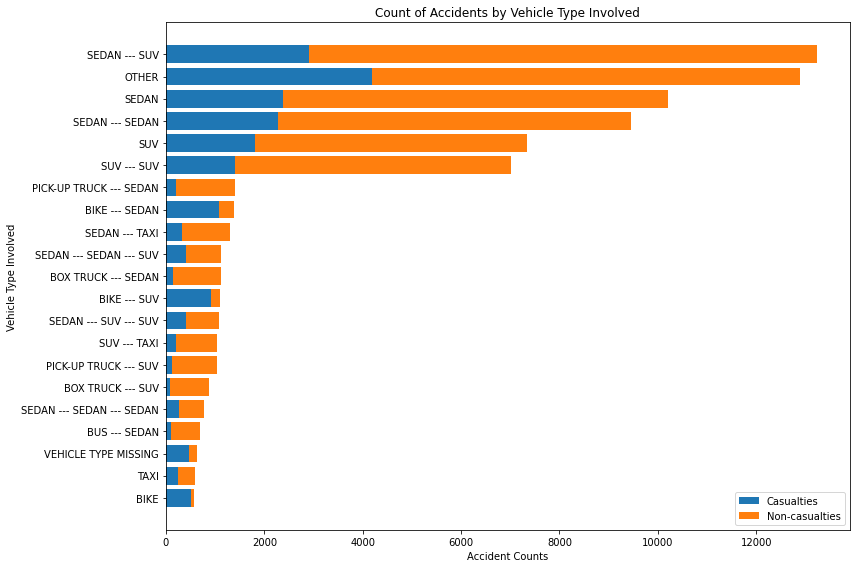

In [ ]:

#define vehicle types 
df_vehicle_types = df[[
    'VEHICLE TYPE MISSING',
    'TAXI',
    'BUS --- SEDAN',
    'BOX TRUCK --- SUV',
    'SUV',
    'BIKE',
    'SEDAN',
    'SEDAN --- SUV --- SUV',
    'BIKE --- SEDAN',
    'SEDAN --- SEDAN --- SUV',
    'BIKE --- SUV',
    'PICK-UP TRUCK --- SUV',
    'SUV --- TAXI',
    'SEDAN --- SUV',
    'SEDAN --- SEDAN',
    'PICK-UP TRUCK --- SEDAN',
    'SEDAN --- TAXI',
    'SUV --- SUV',
    'SEDAN --- SEDAN --- SEDAN',
    'BOX TRUCK --- SEDAN',
    'OTHER',
    'casualty']]

#create separate dfs for accidents involving injury and not 
df_vehicle_types_casulties = df_vehicle_types[df_vehicle_types['casualty'] == 1]
df_vehicle_types_non_casulties = df_vehicle_types[df_vehicle_types['casualty'] == 0]

#create df for accident counts by vehicle types
accident_count_by_vehicle_types = [(a, b, c, d) for a, b, c, d in zip(
    df_vehicle_types.drop(['casualty'], axis = 1).columns, 
    df_vehicle_types.drop(['casualty'], axis = 1).values.sum(axis = 0), 
    df_vehicle_types_casulties.drop(['casualty'], axis = 1).values.sum(axis = 0),
    df_vehicle_types_non_casulties.drop(['casualty'], axis = 1).values.sum(axis = 0))]
accident_count_by_vehicle_types.sort(key = lambda x : x[1])
accident_count_by_vehicle_types_cols = [k for k, _, _, _ in accident_count_by_vehicle_types]
accident_count_by_vehicle_types_casulties = [v for _, _, v, _ in accident_count_by_vehicle_types]
accident_count_by_vehicle_types_non_casulties = [v for _, _, _, v in accident_count_by_vehicle_types]

#create bar plot of accident counts by vehicle types 
plt.figure(figsize = (12, 8))
plt.barh(accident_count_by_vehicle_types_cols, accident_count_by_vehicle_types_casulties, label = "Casualties")
plt.barh(accident_count_by_vehicle_types_cols, accident_count_by_vehicle_types_non_casulties, 
         left = accident_count_by_vehicle_types_casulties, label = "Non-casualties")
plt.xlabel("Accident Counts")
plt.ylabel("Vehicle Type Involved")
plt.legend()
plt.title("Count of Accidents by Vehicle Type Involved")
plt.tight_layout()
plt.savefig("vehicle_type.png", dpi = 300)
plt.show()




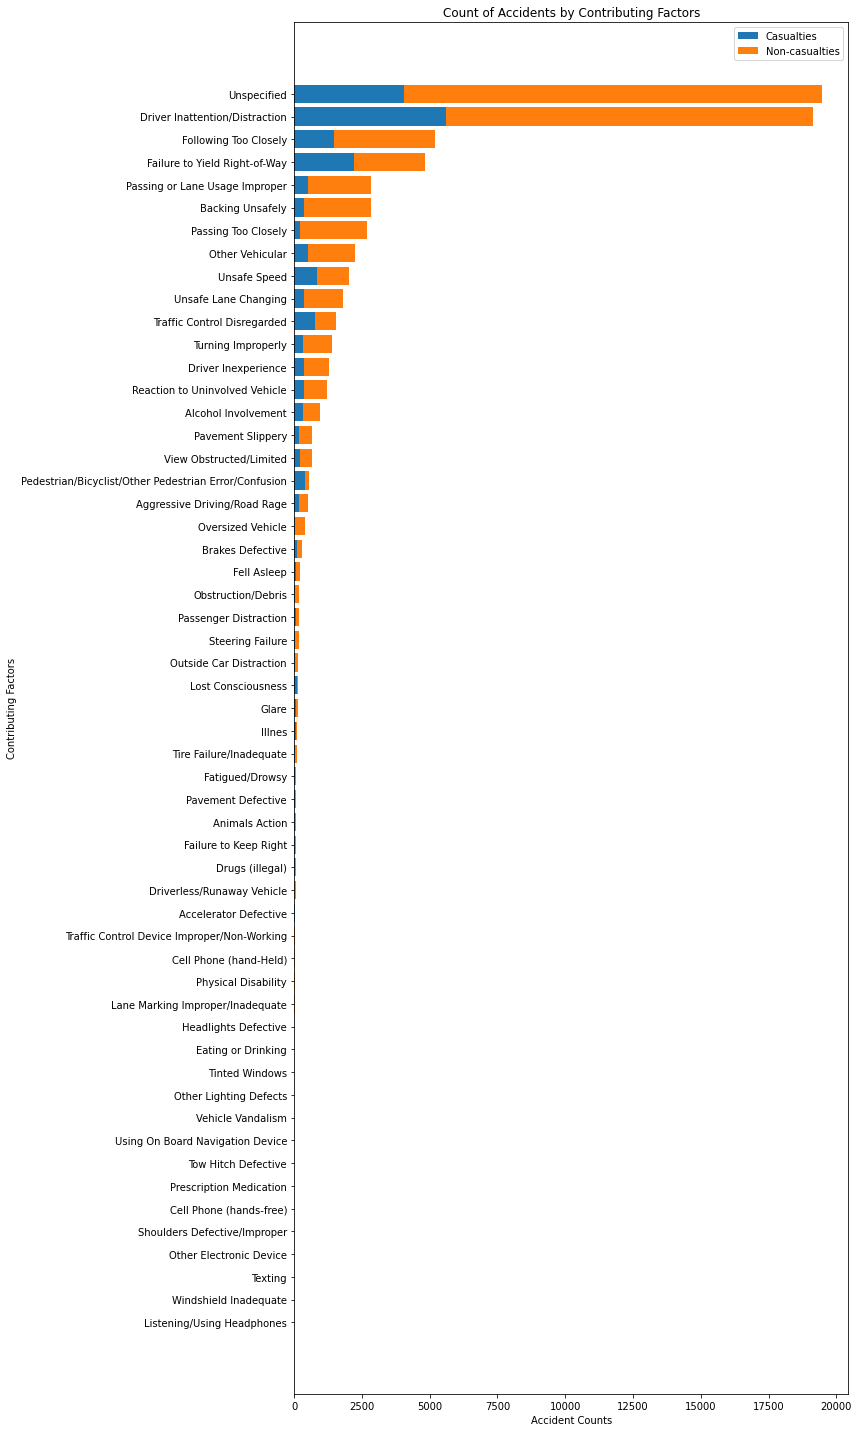

In [ ]:
#create dataframe for contributing factors, by casualty
df_contributing_factors = dummies_factors
df_contributing_factors["casualty"] = df["casualty"]
df_contributing_factors_casulties = df_contributing_factors[df_contributing_factors['casualty'] == 1]
df_contributing_factors_non_casulties = df_contributing_factors[df_contributing_factors['casualty'] == 0]

#create dataframe for accident count by contributing factors 
accident_count_by_contributing_factors = [(a, b, c, d) for a, b, c, d in zip(
    df_contributing_factors.drop(['casualty'], axis = 1).columns, 
    df_contributing_factors.drop(['casualty'], axis = 1).values.sum(axis = 0), 
    df_contributing_factors_casulties.drop(['casualty'], axis = 1).values.sum(axis = 0),
    df_contributing_factors_non_casulties.drop(['casualty'], axis = 1).values.sum(axis = 0))]
accident_count_by_contributing_factors.sort(key = lambda x : x[1])
accident_count_by_contributing_factors_cols = [k for k, _, _, _ in accident_count_by_contributing_factors]
accident_count_by_contributing_factors_casulties = [v for _, _, v, _ in accident_count_by_contributing_factors]
accident_count_by_contributing_factors_non_casulties = [v for _, _, _, v in accident_count_by_contributing_factors]

#bar plot of injury by contributing factors 
plt.figure(figsize = (12, 20))
plt.barh(accident_count_by_contributing_factors_cols, accident_count_by_contributing_factors_casulties, label = "Casualties")
plt.barh(accident_count_by_contributing_factors_cols, accident_count_by_contributing_factors_non_casulties, 
         left = accident_count_by_contributing_factors_casulties, label = "Non-casualties")
plt.xlabel("Accident Counts")
plt.ylabel("Contributing Factors")
plt.legend()
plt.title("Count of Accidents by Contributing Factors")
plt.tight_layout()
plt.savefig("contributing_factor.png", dpi = 300)
plt.show()

# Modeling 

## Baseline model
Our baseline model - the model against which all future models are judged, and which we would expect more sophisticated models to outperform - simply classifies all accidents as not resulting in an injury. This model would have a classification accuracy of about 73 percent. 


In [ ]:
#baseline model - how many of our training set are not injured?
baseline = 1-(y_train.sum()/len(y_train))
print("Baseline model of classifying all accidents as no-injury has classification accuracy of " + str(round(baseline, 3)))


Baseline model of classifying all accidents as no-injury has classification accuracy of 0.728


In [ ]:


#prepare data for running logistic model - get list of all the covariates 
predictors_orig = df["CONTRIBUTING FACTOR VEHICLE 1"].unique().tolist()
types = df["VEHICLE TYPES"].unique().tolist()
boroughs = df["BOROUGH"].unique().tolist()
other_vars = ["month","hour"]

#add to the list 
[predictors_orig.append(i) for i in types]
[predictors_orig.append(i) for i in boroughs]
[predictors_orig.append(i) for i in other_vars]

predictors_orig = [x for x in predictors_orig if pd.isnull(x) == False]
predictors_orig = [x for x in predictors_orig if x != ""]
predictors_orig = [x for x in predictors_orig if x != "casualty"]




In [ ]:

#define function for running logit
def run_logit(X_train, predictors, y_train, X_val, y_val):
  #run model
  logit = LogisticRegressionCV(penalty = "l2", max_iter=5000, cv=10).fit(
      X_train[predictors], y_train
  )
  return logit

def print_predictors(logit, predictors):
   #print out dataframe of top coefficients 
  pred_df = pd.DataFrame(predictors)
  pred_df["Coefficient"] = pd.DataFrame(logit.coef_.reshape(-1, 1))
  pred_df.columns = ["Predictor","Coefficient"]
  pred_df = pred_df.sort_values(by = "Coefficient", ascending=False).head(n=10)
  return pred_df
  

#Function for reporting the accuracy scores and making  ROC plot
def print_output(logit, X_train, y_train, X_val, y_val, predictors): 
  #get and print train/val accuracy scores
  train_preds = logit.predict(X_train[predictors])
  acc_train = accuracy_score(y_train, train_preds)
  val_preds = logit.predict(X_val[predictors])
  acc_val = accuracy_score(y_val, val_preds)
  print("Accuracy score in train = ", str(round(acc_train, 3)) )
  print("Accuracy score in validation = ", str(round(acc_val, 3)) )

  #CODE FOR CREATING ROC PLOT
  #get ROCs for the training and test data
  yhat_train = logit.predict_proba(X_train[predictors])[:,1]
  fpr_train, tpr_train, thresholds_train = roc_curve(y_train, yhat_train)
  yhat_val = logit.predict_proba(X_val[predictors])[:,1]
  fpr_val, tpr_val, thresholds_test = roc_curve(y_val.values, yhat_val)

#write the plot 
  plt.figure(figsize=(10,8))

  x = np.arange(0,100)/100
  plt.plot(x, x, "--", color = "gray", alpha = 0.3)
  plt.plot(fpr_train, tpr_train, label = "Train")
  plt.plot(fpr_val, tpr_val, label = "Test")
  plt.ylabel("True positive rate")
  plt.xlabel("False positive rate")
  plt.title('ROC curve for train and validation data')
  plt.legend()
  plt.show()


## Logistic regression

Our initial attempt to improve on our baseline model is a logistic regression using lasso regularization. Given that our outcome is binary - whether or not an injury occurred - a logistic-classification model is well-suited to our purposes. The model uses 10-fold cross-validation. To evaluate model performance, we look at its classification accuracy in both the training and test sets.

In all of our models, we use the same set of predictors: the one-hot encoded set of vehicle-type combinations; the one-hot encoded set of contributing factors; the one-hot encoded set of borough variables, indicating the borough in which an accident occurred; and two variables measuring the month of year and hour of day in which an accident occurred. 

We also look at the coefficients from the logistic model. This tells us which predictors are most strongly associated with injury. Since our substantive interest is in $\textit{reducing}$ injury, we look at predictors that have a strong positive assoication, as these are those on which policymakers should perhaps focus the most heavily. 

Only two of the top 10 predictors involve vehicles themselves - these are the "BIKE" variable and the "Pedestrian/Bicyclist/Other Pedestrian Error" variable. These indicate that accidents which involve pedestrians or bicyclists are quite likely to result in accidents. 

Most of the other top predictors are contributing factors relating to driver distraction in some way - texting, using headphones, using a cell phone, and using an on-board navigation device. Three of the others involve some phyiscal problem with the driver, such as drug use, losing consciousness, and illness. 


This suggests that policymakers seeking to reduce injury from traffic accidents should focus on three types of accidents: Those involving bicycles, those which involve medical issues on the part of drivers, and those which involve driver distraction. 

In [ ]:
logit1 = run_logit(X_train, predictors_orig, y_train, X_val, y_val)
print_predictors(logit1, predictors_orig)

,Predictor,Coefficient
27,Lost Consciousness,2.079746
30,Illnes,1.753089
41,Prescription Medication,1.573577
69,BIKE,1.509623
38,Using On Board Navigation Device,1.041250
43,Cell Phone (hands-free),0.876869
53,Texting,0.836634
15,Pedestrian/Bicyclist/Other Pedestrian Error/Co...,0.792688
29,Traffic Control Device Improper/Non-Working,0.734380
52,Listening/Using Headphones,0.598144


Accuracy score in train =  0.762
Accuracy score in validation =  0.765


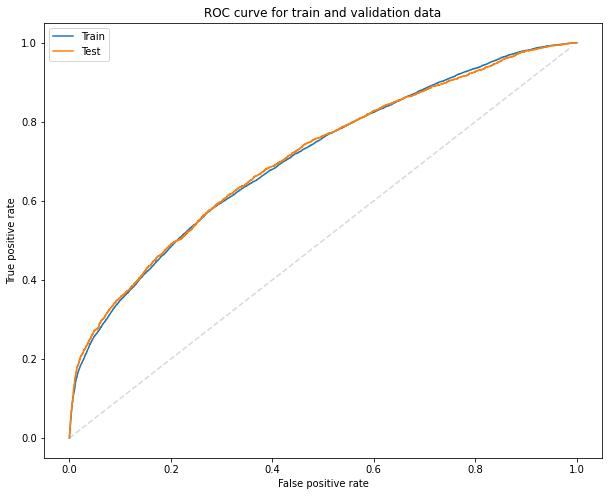

In [ ]:
print_output(logit1, X_train, y_train, X_val, y_val, predictors_orig)

## Logistic model performance

Our model does indeed outperform the baseline model, which achieves a 72.8 percent accuracy rate by classifying all accidents as non-injuries. Our logistic model classifies 76.5 percent of observations accurately in the validation set. But this is only a mild improvement over the baseline, so we turn to other models to see whether they might outperform. 


# Bagging 

After running the logistic model, we are interested in whether other models can outperform both the baseline and the logit. The first model we test is a decision tree. To find the best depth of the tree, we test a variety of decision-tree depths in a bagging model in the training and validation data; we then use the depth that produces the highest accuracy score in the validation data as the "best depth" for the decision tree.  

Somewhat interestingly, we find that the decision-tree model actually underperforms the logistic model (very slightly), though it outperforms the baseline. 


In [ ]:

#build bagging decision tree classifier to find best max_depth for random forest
max_depths = np.arange(1,30,1).tolist()
acc_scores, test_acc_scores = [], []
#loop over depths
for depth in max_depths:
    #initialize decision tree classifier and bagging
    basemodel = DecisionTreeClassifier(max_depth = depth, random_state = 144)
    bagging = BaggingClassifier(base_estimator = basemodel)
    bagging.fit(X_train[predictors_orig], y_train)
    #get validation accuracy
    val_pred = bagging.predict(X_val[predictors_orig])
    val_acc = accuracy_score(y_val, val_pred)
    acc_scores.append(val_acc)

    #get test accuracy - we won't look at this until later
    test_pred = bagging.predict(X_test[predictors_orig])
    test_acc = accuracy_score(y_test, test_pred)
    test_acc_scores.append(test_acc)
    


best_depth = max_depths[acc_scores.index(max(acc_scores))]
bagging_test_acc = test_acc_scores[acc_scores.index(max(acc_scores))]
print("Best decision tree model has accuracy of ", str(round(max(acc_scores), 3)))

Best decision tree model has accuracy of  0.762


# Random forest classifier

Our exploration of different models continues with a random forest classifier. How does this perform relative to the baseline model, the logistic model, and the decision tree? For the trees, we use the depth which produced the highest accuracy score in the bagging model above. We see that the random forest slightly underperforms both the best decision tree estimator and the logistic regression.


In [ ]:
#BUILD RANDOM FOREST CLASSIFIER using best depth from above
#  and set the maximum depth to be max_depth and use 500 estimators
random_forest = RandomForestClassifier(random_state = 144, max_depth = best_depth, n_estimators = 500)

# Fit the model on the training set
random_forest.fit(X_train[predictors_orig], y_train)

rf_preds = random_forest.predict(X_val[predictors_orig])
rf_acc_val = accuracy_score(y_val, rf_preds)

rf_preds_test = random_forest.predict(X_test[predictors_orig])
rf_acc_test = accuracy_score(y_test, rf_preds_test)

print("RF accuracy = ", str(round(rf_acc_val, 4)))

RF accuracy =  0.7541


# Adaboost Classifier

We look as well at the performance of an AdaBoost classifier, using the same depth as above and using 9 estimators. Again, the classifier slightly underperforms the logistic model. 

In [ ]:

#MAKE ADABOOST CLASSIFIER
y_val_ada = np.where(y_val.values == 0, -1, 1)
y_train_ada = np.where(y_train.values == 0, -1, 1)
#use best depth from above
boost = AdaBoostClassifier( base_estimator = DecisionTreeClassifier(max_depth = best_depth), 
                            algorithm = 'SAMME', n_estimators=9)
boost.fit(X_train[predictors_orig], y_train)
ada_preds = boost.predict(X_val[predictors_orig])
ada_acc = accuracy_score(ada_preds, y_val)
ada_preds_test = boost.predict(X_test[predictors_orig])
ada_acc_test = accuracy_score(y_test, ada_preds_test)
print("AdaBoost accuracy in validation = ", str(round(ada_acc, 3)))
#this is also lower than the logit accuracy! 


AdaBoost accuracy in validation =  0.761


# Improving the Model

Based on the analyses in the previous section, we conclude that the logistic model is the preferred model, which we will focus on fine-tuning in the remainder of the project. Our reasons here are twofold. First, the logistic model is consistently the best-performing at prediction, beating out more complex algorithms. Second, given our question's context - in which we are trying both to predict injury and understand the factors which lead to injury - the logistic model is particularly apt, as it produces easily-interpretable coefficients that allow us to isolate the association between particular variables and the incidence of the outcome. The tree and boosting models are not as easily interpretable, which is part of our reasoning not to select them. 

Our model is not performing enormously better than the baseline. While this is not a problem per se, we would prefer a better-performing model. Accordingly, we make a few adjustments to the data, in the hope of getting a better-performing model. 

First, we code a binary variable for whether an accident occurred on a highway. We do so by manually classifying the type of street on which an accident is reported as occurring; we count freeways, expressways, highways, parkways, turnpikes, roadways, and ramps as highways. 

Second, we make some attempts to reduce the sparsity of our data matrix. Rather than simply one-hot encoding all vehicle-type combinations, we create a set of indicator variables that tells us whether a certain type of vehicle was involved in an accident.  To this, we add a variable on the number of vehicles involved in the accident. (We do this because we are somewhat concerned about the mechanical effect whereby accidents involving more vehicles have a higher chance of having an injury, solely because more people are involved in the accident.) These steps reduce the sparsity of our matrix, as we now describe accidents using 10 columns, rather than the previous 20. 

We perform a similar process with the contributing-factors variable. Again, in an effort to reduce sparsity, we aggregate factors that are similar to each other into one category. We focus on five categories in particular: factors involving drugs or the physical health of the driver; factors involving driver distraction; factors involving problems with the vehicle; factors involving driver error in traffic, or a failure to follow traffic laws properly; and factors involving problems with the road, such as debris or obstruction. While this leaves some factors - such as driver inexperience - unaggregated, this aggregation process reduces the number of contributing factors by 41. When we one-hot encode the data, this should reduce our sparsity considerably. 

In [ ]:
#get the street type of each incident by splitting street name string to get type of street
street_names = []
for i in range(len(df)):
  #this deals with NAs
  if type(df["ON STREET NAME"][i]) == float:
    street_names.append("")
  else: 
    street_names.append(df["ON STREET NAME"][i].split()[-1]) 


#define list of highways from this list
highways = ["(BQE)", "BELT","EXPRESSWAY","EXPWAY","EXPWY","EXPY",
            "Expressway","FREEWAY","Freeway", "Fwy","HIGHWAY","PARKWAY","ROADWAY",
            "ROADWA","THRUWAY","TPKE","TUNNEL","TURNPIKE","Thruway",
            "expressway","expresway","expwy","freeway","highway","overpass",
            "parkway","parkwy","pkwy","ramp"]
            
#create binary variable for whether street is a highway
is_highway = []
for name in street_names:
  if name in highways:
    is_highway.append(1)
  else: 
    is_highway.append(0)
df["is_highway"] = is_highway

In [ ]:
#Aggregate the vehicle-type categories
#code for cleaning the vehicle type variable
def count_num_vehicles_involved(lst):
    count = 0
    for vehicle in lst:
        if vehicle:
            count += 1
    return count

def vehicle_involved_indicator(lst, vehicle_type):
    return 1 if any(vehicle_type in v for v in lst) else 0

def vehicle_type_missing_indicator(lst):
    return 0 if any(lst) else 1

car_types_df = df[["VEHICLE TYPE CODE 1",
                    "VEHICLE TYPE CODE 2",
                    "VEHICLE TYPE CODE 3",
                    "VEHICLE TYPE CODE 4",
                    "VEHICLE TYPE CODE 5"]]
car_types_df = car_types_df.fillna("")

df["NUM VEHICLES INVOLVED"] = [count_num_vehicles_involved(lst) for lst in car_types_df.values]
df["SEDAN INVOLVED"] = [vehicle_involved_indicator(lst, "SEDAN") for lst in car_types_df.values]
df["SUV INVOLVED"] = [vehicle_involved_indicator(lst, "SUV") for lst in car_types_df.values]
df["BIKE INVOLVED"] = [vehicle_involved_indicator(lst, "BIKE") for lst in car_types_df.values]
df["MOTORCYCLE INVOLVED"] = [vehicle_involved_indicator(lst, "MOTORCYCLE") for lst in car_types_df.values]
df["TRUCK INVOLVED"] = [vehicle_involved_indicator(lst, "TRUC") for lst in car_types_df.values]
df["TAXI INVOLVED"] = [vehicle_involved_indicator(lst, "TAXI") for lst in car_types_df.values]
df["BUS INVOLVED"] = [vehicle_involved_indicator(lst, "BUS") for lst in car_types_df.values]
df["VEHICLE TYPE MISSING"] = [vehicle_type_missing_indicator(lst) for lst in car_types_df.values]
df = df.drop(["VEHICLE TYPE CODE 1",
                "VEHICLE TYPE CODE 2",
                "VEHICLE TYPE CODE 3",
                "VEHICLE TYPE CODE 4",
                "VEHICLE TYPE CODE 5"], axis = 1)

In [ ]:
#Aggregate the contributing-factors variable 
distraction = ["Driver Inattention/Distraction",
              "Passenger Distraction","Outside Car Distraction",
               "Using On Board Navigation Device","Cell Phone (hand-Held)",
               "Cell Phone (hands-free)","Other Electronic Device",
               "Eating or Drinking","Listening/Using Headphones","Texting"]

health_or_drugs = ["Alcohol Involvement","Fell Asleep",
                   "Lost Consciousness","Illnes",
                   "Fatigued/Drowsy", "Drugs (illegal)",
                   "Prescription Medication","Physical Disability"]

vehicle_problem = ["Oversized Vehicle","Brakes Defective",
                   "Steering Failure","Tire Failure/Inadequate","Tinted Windows",
                   "Accelerator Defective","Headlights Defective","Other Vehicular",
                   "Tow Hitch Defective","Other Lighting Defects",
                   "Windshield Inadequate"]

traffic_error = ["Passing Too Closely","Backing Unsafely",
                "Failure to Yield Right-of-Way","Unsafe Lane Changing",
                "Following Too Closely","Failure to Keep Right",
                "Passing or Lane Usage Improper","Traffic Control Disregarded",
                 "Aggressive Driving/Road Rage","Turning Improperly"]

road_problem = ["Pavement Slippery","Obstruction/Debris",
                "View Obstructed/Limited","Pavement Defective",
                "Traffic Control Device Improper/Non-Working",
                "Lane Marking Improper/Inadequate","Shoulders Defective/Improper"]
#now aggregate the variable
cause = []
for i in range(len(df)):
  #this deals with NAs
  if type(df['CONTRIBUTING FACTOR VEHICLE 1'][i]) == float:
    cause.append("")
  elif df["CONTRIBUTING FACTOR VEHICLE 1"][i] in distraction:
    cause.append("Distraction")
  elif df["CONTRIBUTING FACTOR VEHICLE 1"][i] in health_or_drugs:
    cause.append("Driver Health / Drugs")
  elif df["CONTRIBUTING FACTOR VEHICLE 1"][i] in vehicle_problem:
    cause.append("Vehicle Problem")
  elif df["CONTRIBUTING FACTOR VEHICLE 1"][i] in traffic_error:
    cause.append("Driver Traffic Error")
  elif df["CONTRIBUTING FACTOR VEHICLE 1"][i] in road_problem:
    cause.append("Problem with Road")
  else: 
    cause.append(df['CONTRIBUTING FACTOR VEHICLE 1'][i])

df["cause"] = cause

#one-hot encode the cause variable
cause_dummies = pd.get_dummies(df["cause"])
df = df.drop(['Animals Action', 'Driver Inexperience', 'Driverless/Runaway Vehicle',
       'Glare', 'Pedestrian/Bicyclist/Other Pedestrian Error/Confusion',
       'Reaction to Uninvolved Vehicle', 'Unsafe Speed', 'Unspecified',
       'Vehicle Vandalism'], axis = 1)
df = df.join(cause_dummies)


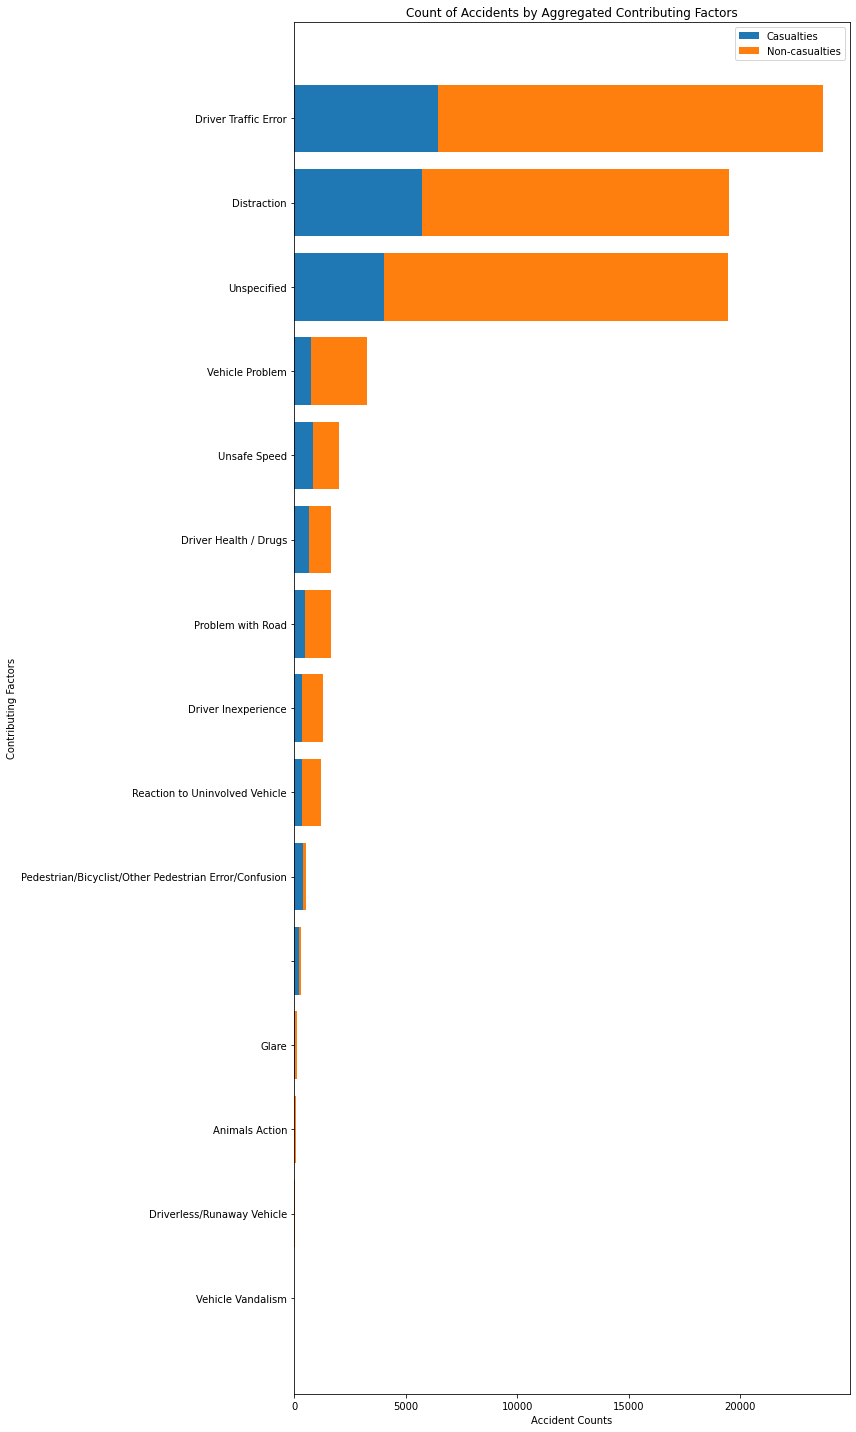

In [ ]:
#create dataframe for contributing factors, by casualty
df_contributing_factors = cause_dummies
df_contributing_factors["casualty"] = df["casualty"]
df_contributing_factors_casulties = df_contributing_factors[df_contributing_factors['casualty'] == 1]
df_contributing_factors_non_casulties = df_contributing_factors[df_contributing_factors['casualty'] == 0]

#create dataframe for accident count by contributing factors 
accident_count_by_contributing_factors = [(a, b, c, d) for a, b, c, d in zip(
    df_contributing_factors.drop(['casualty'], axis = 1).columns, 
    df_contributing_factors.drop(['casualty'], axis = 1).values.sum(axis = 0), 
    df_contributing_factors_casulties.drop(['casualty'], axis = 1).values.sum(axis = 0),
    df_contributing_factors_non_casulties.drop(['casualty'], axis = 1).values.sum(axis = 0))]
accident_count_by_contributing_factors.sort(key = lambda x : x[1])
accident_count_by_contributing_factors_cols = [k for k, _, _, _ in accident_count_by_contributing_factors]
accident_count_by_contributing_factors_casulties = [v for _, _, v, _ in accident_count_by_contributing_factors]
accident_count_by_contributing_factors_non_casulties = [v for _, _, _, v in accident_count_by_contributing_factors]

#bar plot of injury by contributing factors 
plt.figure(figsize = (12, 20))
plt.barh(accident_count_by_contributing_factors_cols, accident_count_by_contributing_factors_casulties, label = "Casualties")
plt.barh(accident_count_by_contributing_factors_cols, accident_count_by_contributing_factors_non_casulties, 
         left = accident_count_by_contributing_factors_casulties, label = "Non-casualties")
plt.xlabel("Accident Counts")
plt.ylabel("Contributing Factors")
plt.legend()
plt.title("Count of Accidents by Aggregated Contributing Factors")

plt.tight_layout()
plt.savefig("contributing_factor.png", dpi = 300)
plt.show()

In [ ]:
#define new list of predictors
predictors = df["cause"].unique().tolist()
types = ["NUM VEHICLES INVOLVED",
         "SEDAN INVOLVED","SUV INVOLVED",'BIKE INVOLVED',
         "MOTORCYCLE INVOLVED","TRUCK INVOLVED","TAXI INVOLVED",
         "BUS INVOLVED","VEHICLE TYPE MISSING"]
boroughs = df["BOROUGH"].unique().tolist()
other_vars = ["month","hour","is_highway"]
census_vars = ["Drive At All %", "Median Income",
               "Median Age","HS+",
               "Non-Minority White %",
               "Population Density"]

[predictors.append(i) for i in types]
[predictors.append(i) for i in boroughs]
[predictors.append(i) for i in other_vars]
[predictors.append(i) for i in census_vars]
predictors = [x for x in predictors if pd.isnull(x) == False]
predictors = [x for x in predictors if x != ""]
predictors.append("casualty")


In [ ]:
#re-do the train-validation-test split, so we can run the models again
df_new = df[predictors]
df_new = df_new.dropna()
predictors_new = [x for x in predictors if x != "casualty"]
X = df_new[predictors_new]
y = df_new["casualty"]

X_train, X_test_new, y_train, y_test_new = train_test_split(X, y, test_size = 0.2, random_state = 42)
#create train-validation split 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [ ]:
#Scale the data, now that we have non-binary predictors
X_train_scale = X_train[predictors_new]
X_test_new_scale = X_test_new[predictors_new]
X_val_scale = X_val[predictors_new]
scaler = MinMaxScaler()
# #replace the data assigned above with the scaled versions - this retains the right indices! 
X_train_scale[:] = scaler.fit_transform(X_train[predictors_new])
X_test_new_scale[:] = scaler.fit_transform(X_test_new[predictors_new])
X_val_scale[:] = scaler.fit_transform(X_val[predictors_new])


# Running the improved model

We now test whether our model performance has improved, after having made the adjustments to the data. To test this, we use the best-performing model from above: the lasso-like logistic regression with cross-validation. 

We see that our model performance has indeed improved. Our accuracy in validation data is now about 77.1 percent, up about half a percentage point from the previous logistic model. Given that our previous model only outperformed the baseline by 3 percentage points, we have effectively improved our model performance about 15 percent.

We also see that our set of most prominent predictors has had some changes. What stands out from set of prominent predictors is that accidents involving bicycles, motorcycles, or pedestrians are quite likely to end in an injury, as are accidents that involve more cars (which was part of our reasoning for including the variable in the first place). That "Vehicle Type Missing" is a strong predictor is perhaps strange, but we interpret this as essentially an indicator for whether the accident was a hit-and-run. If the driver did flee after the accident, the vehicle type might go unreported; moreover, these accidents would only be reported in the first place if an injury occurred. 


In [ ]:
#run the logit function defined above 
logit2 = run_logit(X_train_scale, predictors_new, y_train, X_val_scale, y_val)

print_predictors(logit2, predictors_new)


,Predictor,Coefficient
17,BIKE INVOLVED,2.613697
22,VEHICLE TYPE MISSING,2.142146
18,MOTORCYCLE INVOLVED,1.565868
8,Pedestrian/Bicyclist/Other Pedestrian Error/Co...,0.762206
14,NUM VEHICLES INVOLVED,0.755689
11,Glare,0.634121
29,hour,0.400797
34,HS+,0.350903
9,Driver Health / Drugs,0.269094
30,is_highway,0.245977


Accuracy score in train =  0.768
Accuracy score in validation =  0.772


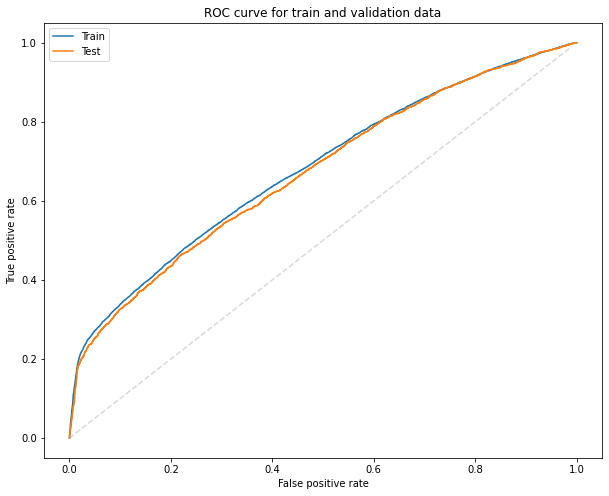

In [ ]:
print_output(logit2, X_train_scale, y_train, X_val_scale, y_val, predictors_new)

# Comparing model performance in the test set

Finally, we turn to the test set to see how the models perform. 

In [ ]:
logit1_preds_test = logit1.predict(X_test[predictors_orig])
logit1_acc_test = accuracy_score(y_test, logit1_preds_test)
logit2_preds_test = logit2.predict(X_test_new_scale[predictors_new])
logit2_acc_test = accuracy_score(y_test_new, logit2_preds_test)

In [ ]:
print("Original logit test accuracy  = ", str(round(logit1_acc_test, 3)))
print("Updated logit test accuracy  = ", str(round(logit2_acc_test, 3)))
print("Bagging test accuracy  = ", str(round(bagging_test_acc, 3)))
print("Random forest test accuracy = ", str(round(rf_acc_test, 3)))
print("AdaBoost test accuracy = ", str(round(ada_acc_test, 3)))
print("Baseline accuracy = ", str(round(baseline, 3)))

Original logit test accuracy  =  0.759
Updated logit test accuracy  =  0.767
Bagging test accuracy  =  0.754
Random forest test accuracy =  0.749
AdaBoost test accuracy =  0.754
Baseline accuracy =  0.728


Accordingly, it looks like the updated logit is the best performer in the test data. The performance of the various trees and boosting models is quite underwhelming. All of the models outperform the baseline, but not by much. Our conclusion from this is that, given our current data, injury is quite hard to predict. Better predictions would require additional data on the characteristics of traffic accidents. 